


## Installed different packages required for our project.


---





In [2]:
!pip install category_encoders
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 82 kB 393 kB/s 
     |████████████████████████████████| 34.0 MB 38 kB/s 
     |████████████████████████████████| 13.1 MB 6.9 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=331570fbf2b3fb69b1e8065bcecd642d7b27680b927ad58d7144f8202d739e68
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 371 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509254 sha256=6e615d4b106e9de43fb773bcc73babd77ec585e7548099737464b4d0e647bfcb
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


## We imported and brought in a multitude of libraries and functions for our project.

---



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from category_encoders import OneHotEncoder, OrdinalEncoder

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##We proceeded to pull our dataframe from google drives.

---



In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/My Drive/Unit 2


/content/gdrive/My Drive/Unit 2


In [6]:
!ls

 Dept_Bridges.csv  'NY_Bridges - Sheet1.csv'   pipline.joblib


In [77]:
here = ('NY_Bridges - Sheet1.csv')

## We created a function that dropped high cardinality columns and null values and then converted columns to 1's and 0's for use in our pipeline. We also changed our index column to reflect the dates that were inspected

---



In [80]:

def wrangle(filepath):
    df = pd.read_csv(filepath,header=0,index_col='Date.Inspected', parse_dates=['Date.Inspected'])
    df = df.drop(columns='Manhattan')
    df = df.drop(columns='Location')
    df = df.drop(columns='YearInspected')
    df = df.drop(columns='County')
    

    df['Condition'] = (df['Condition']>=5)
    df['Condition'] = df['Condition'].astype(int)
    df['SD.FO.Status'] = (df['SD.FO.Status']=='N')
    df['SD.FO.Status'] = (df['SD.FO.Status'].astype(int))
    df = df.dropna()
    df['AgeAtInspection'] = df['AgeAtInspection'].astype(str).str[0:5].astype(float)
    df = df[(df['AgeAtInspection'] >=.01)]
    df= df[(df['AgeAtInspection'] < 100)]
    
    df = df.dropna()
    return df

In [81]:
df = wrangle(here)

## I then proceeded to do some data exploration. 

---



In [82]:
df.describe()

,Built,SD.FO.Status,Condition,AgeAtInspection
count,16784.000000,16784.000000,16784.000000,16784.000000
mean,1970.404552,0.638704,0.647104,44.703398
std,24.778525,0.480391,0.477885,24.791501
min,1900.000000,0.000000,0.000000,0.216000
25%,1954.000000,0.000000,0.000000,23.470000
50%,1969.000000,1.000000,1.000000,46.260000
75%,1991.000000,1.000000,1.000000,61.522500
max,2015.000000,1.000000,1.000000,99.890000


In [60]:
df

,Municipality,Route,Owner,Built,SD.FO.Status,Condition,AgeAtInspection
Date.Inspected,,,,,,,
2014-09-04,Albany City,5 X,City,1968,1,1,46.67
2015-10-27,Albany City,9 9 11081025,NYSDOT,1971,1,0,44.81
2015-07-08,Albany City,9 9 11081028,NYSDOT,1971,0,0,44.51
2015-10-14,Albany City,9 X,NYSDOT,1969,0,0,46.78
2015-05-07,Albany City,9W 9W11012007,NYSDOT,1966,0,0,49.34
...,...,...,...,...,...,...,...
2014-10-01,Starkey Town,14 14 66031018,NYSDOT,1998,1,1,16.74
2015-10-26,Starkey Town,CASTLE POINT ROAD,County,2005,1,1,10.81
2014-06-30,Starkey Town,GLENORA ROAD,County,1985,1,1,29.49


In [61]:
df['Route'].value_counts()

90IX                 119
87IX                  56
MAIN STREET           42
MILL STREET           33
COUNTY ROAD 16        30
                    ... 
FINE CNTN LSBN RD      1
North Petersboro       1
WEST233 STREET         1
34  34 65011012        1
RDWYITORAMPB C ER      1
Name: Route, Length: 12317, dtype: int64

In [62]:
df['Condition'].value_counts()

1    10861
0     5923
Name: Condition, dtype: int64

In [63]:
df['SD.FO.Status'].value_counts()

1    10720
0     6064
Name: SD.FO.Status, dtype: int64

In [87]:
here = df[(df['Condition']==1)]
here = here.dropna()
here['Owner'].value_counts()
print(here['Owner'].value_counts()/df['Owner'].value_counts())

Alleghany State Park Authority                                   0.666667
Authority or Commission - Other                                  0.666667
Central NY State Park Commission                                 1.000000
City                                                             0.486250
City of NY State Park Commission                                 0.666667
County                                                           0.697026
Federal (Other than those listed below)                               NaN
Finger Lakes Parks and Recreation Commission                          NaN
Genesee State Parks and Recreation Commission                    0.600000
MTA Tunnels and Bridges (aka TBTA)                               0.276596
Metropolitan Transportation Authority                            0.666667
NYC Dept of Water Supply, Gas and Electric                       0.700000
NYS Bridge Authority                                             0.222222
NYS Dept of Environmental Conservation

In [ ]:
model = ols('Condition ~ AgeAtInspection + Municipality', data=df).fit()

print(model.summary())

## I then proceeded to create my target variables as well as training variables.

---



In [89]:
target = 'Condition'
y = df['Condition']
X = df.drop(columns=target)

In [90]:
print(X.shape)
print(y.shape)

(16784, 6)
(16784,)


In [92]:
X_train, X_val,y_train,y_val = train_test_split(X,y,random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(12588, 6)
(4196, 6)
(12588,)
(4196,)


## I then made my baseline.

---



In [93]:
y_train.value_counts(normalize=True).max()


0.6487130600571973

## We then made a logistic regression pipeline and printed the results.

---



In [94]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(), 
    LogisticRegression()

)

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Municipality', 'Route', 'Owner'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,

In [95]:
print('Training Accuracy', model.score(X_train,y_train))
print('Validation Accuracy', model.score(X_val,y_val))

Training Accuracy 0.9764061010486177
Validation Accuracy 0.6908960915157293


## We then used the data and did a DecisionTreeClassifier also printing the results.

---



In [96]:
model_dt = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42, max_depth=15)
)

model_dt.fit(X_train, y_train);

In [97]:
print('model_dt accuracy score for training', accuracy_score(y_train, model_dt.predict(X_train)))
print('model_dt accuracy score for val', accuracy_score(y_val, model_dt.predict(X_val)))

model_dt accuracy score for training 0.8850492532570702
model_dt accuracy score for val 0.6732602478551001


##We then made a chart with the most important features.

---



Text(0.5, 0, 'Importance')

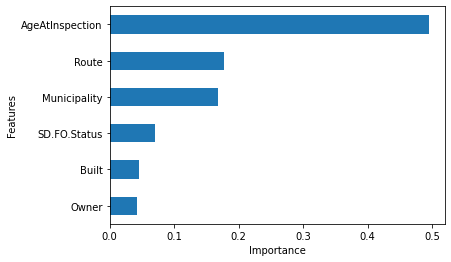

In [98]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_ 
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('Features')
plt.xlabel('Importance')

## We made another pipeline using the GridSearch method with randomforestclassifiers (Brute force). 

---



In [105]:
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)


param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(6, 40, 6),
    'randomforestclassifier__n_estimators': range(25, 125, 25)
}

model_rfgs = GridSearchCV(
    clf,
    param_grid = param_grid,
    n_jobs=-1,
    cv=6,
    verbose=1 
)

model_rfgs.fit(X, y)

Fitting 6 folds for each of 48 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  4.3min finished


GridSearchCV(cv=6, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=None,
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=None,
                                                       return_df=True,
                                                       verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
          

In [106]:
print(model_rfgs.best_estimator_)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Municipality', 'Route', 'Owner'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Municipality',
                                          'data_type': dtype('O'),
                                          'mapping': Albany City                1
Berne Town                 2
Bethlehem Town             3
Coeymans Town              4
Cohoes City                5
                        ... 
Penn Yan Village (Pt    1355
Potter Town             1356
Starkey Town            1357
Torrey To...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=6, max_features='auto',
                                        max_leaf_nodes=

##I then performed a RandomizedSearchCV and got the results.

---



In [100]:
model_rfrs = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_jobs=-1,
    cv=7,
    verbose=1,
    n_iter = 8
)

model_rfrs.fit(X,y)

Fitting 7 folds for each of 8 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:   54.3s finished


RandomizedSearchCV(cv=7, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [101]:
print(model_rfrs.score(X_val,y_val))

0.7619161105815062


In [102]:
print(model_rfrs.best_params_)
print(model_rfrs.best_score_)

{'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 25, 'randomforestclassifier__max_depth': 6}
0.7104981896579192


##We then set up the function for PDP plots and explored a little bit.

---



In [107]:
feature = 'AgeAtInspection'

isolated = pdp_isolate(
    model=model_rfrs, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

In [108]:
isolated.percentile_info

array(['(0.0)', '(11.11)', '(22.22)', '(33.33)', '(44.44)', '(55.56)',
       '(66.67)', '(77.78)', '(88.89)', '(100.0)'], dtype=object)

In [353]:
isolated.pdp

array([0.75185864, 0.75178311, 0.73301569, 0.66191956, 0.59950191,
       0.5667928 , 0.53705099, 0.53381348, 0.51767308, 0.52356955])

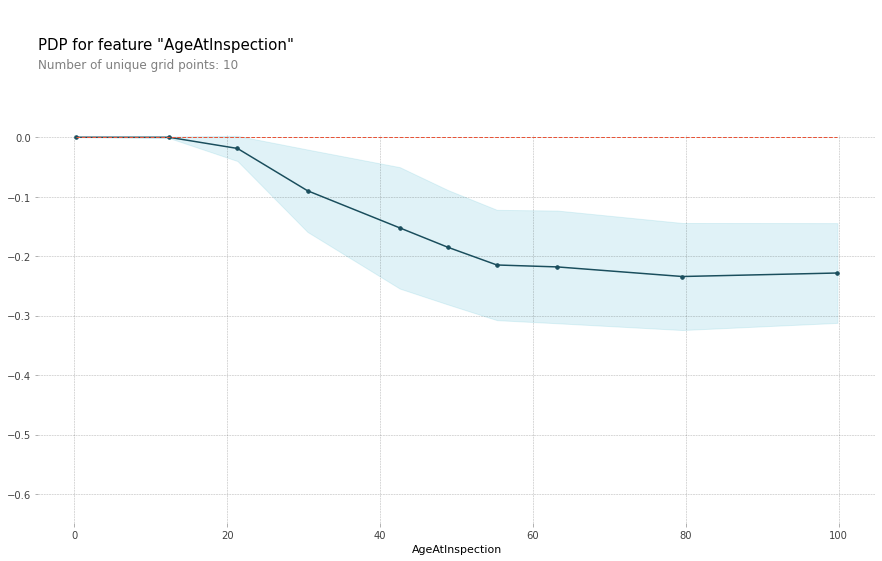

In [354]:
pdp_plot(isolated, feature_name=feature);

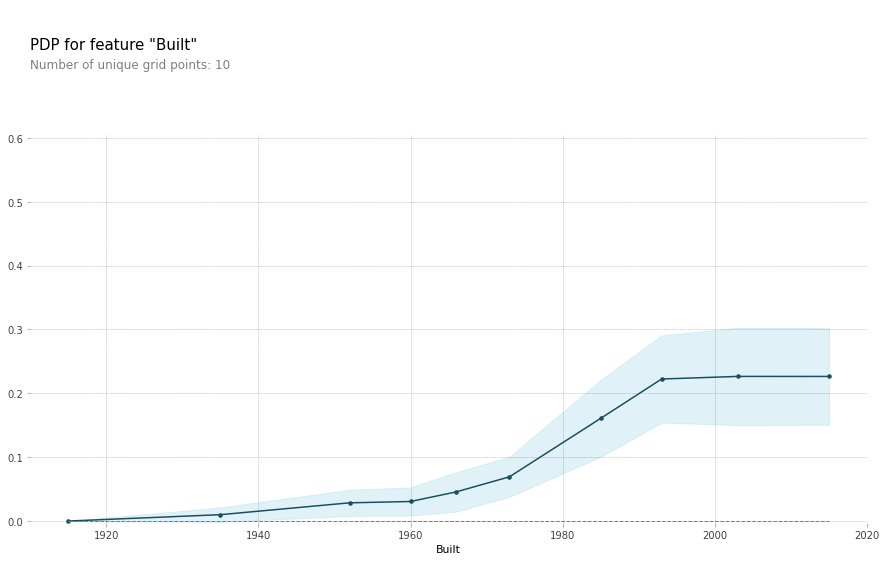

In [355]:
feature = 'Built'

isolated = pdp_isolate(
    model=model_rfrs, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

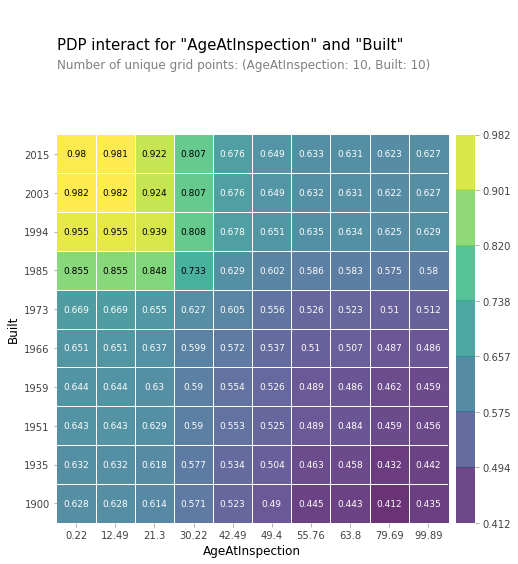

In [362]:
features = ['AgeAtInspection', 'Built']


interaction = pdp_interact(model_rfrs,dataset=df.dropna(),model_features=X_val.columns,features=features)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

##The we did an ROC plot curve with the different pipelines.

---



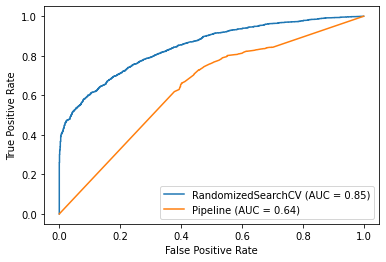

In [356]:
fig1 = plot_roc_curve(model_rfrs, X_val, y_val)
fig2 = plot_roc_curve(model_dt, X_val, y_val, ax = fig1.ax_);

In [357]:
model_cr = classification_report(y_val, model_rfrs.predict(X_val))
print(model_cr)

              precision    recall  f1-score   support

           0       0.69      0.61      0.65      1501
           1       0.80      0.85      0.82      2695

    accuracy                           0.76      4196
   macro avg       0.74      0.73      0.74      4196
weighted avg       0.76      0.76      0.76      4196

